
Archivo: ReposoECG_original.txt
MSE después del filtrado: 0.0001
SNR después del filtrado: 17.84 dB


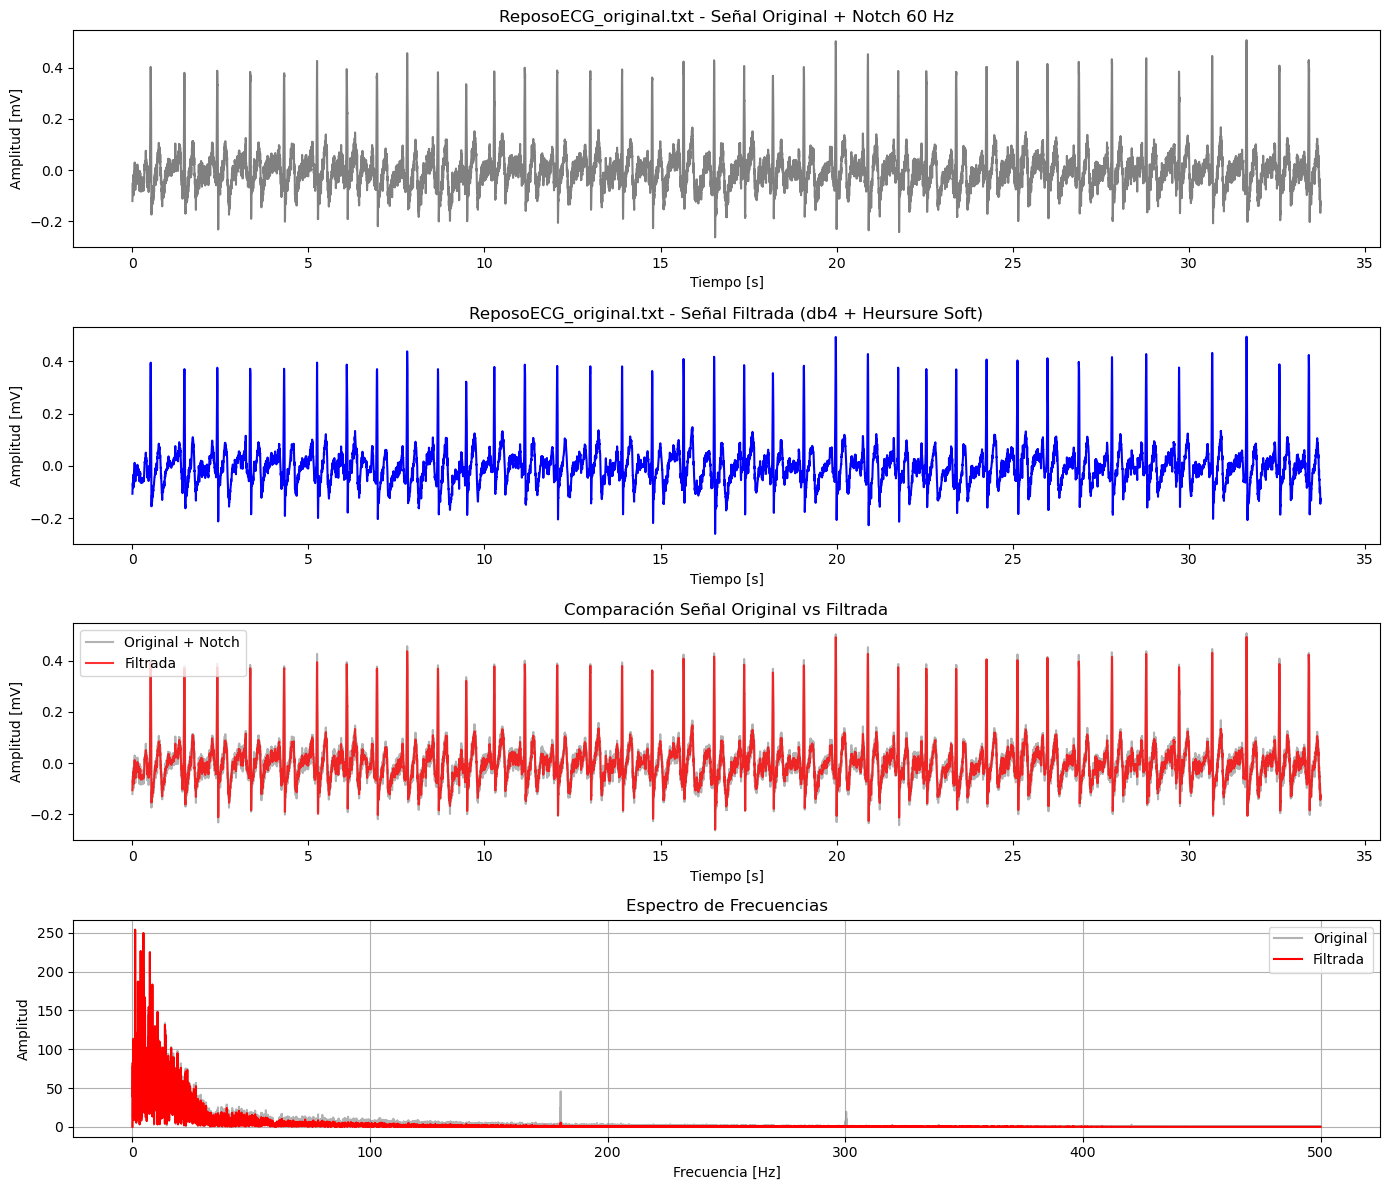

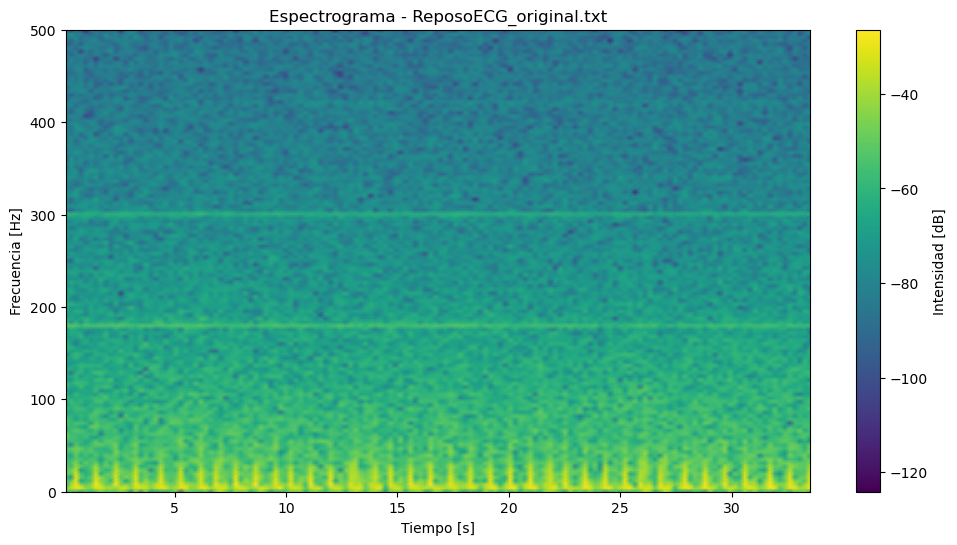

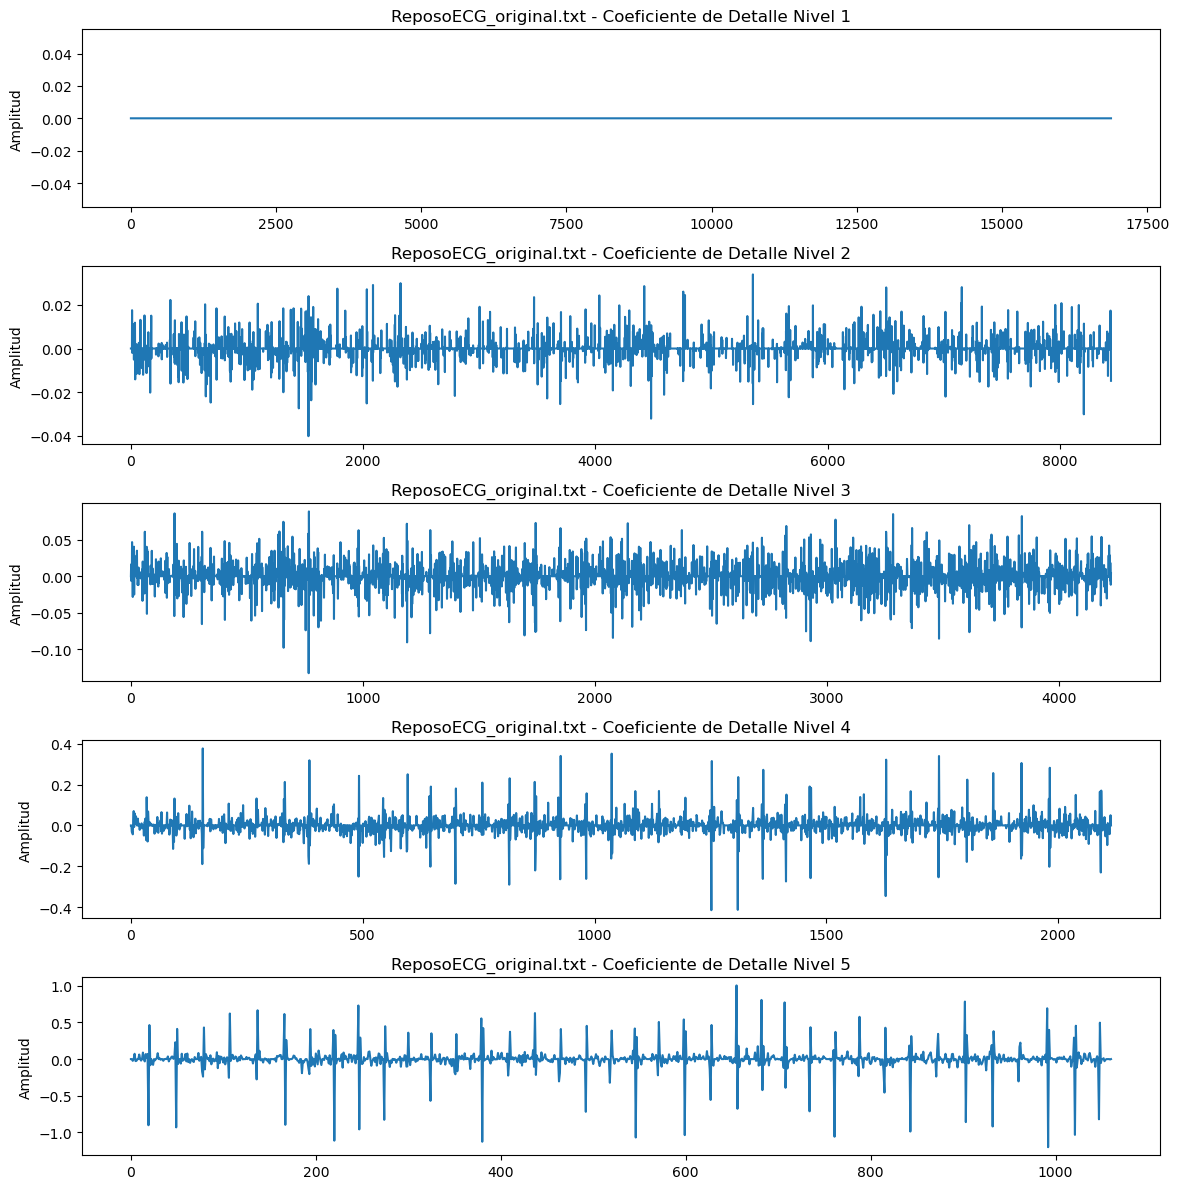


Archivo: PrimeraDerivada.txt
MSE después del filtrado: 0.0000
SNR después del filtrado: 22.20 dB


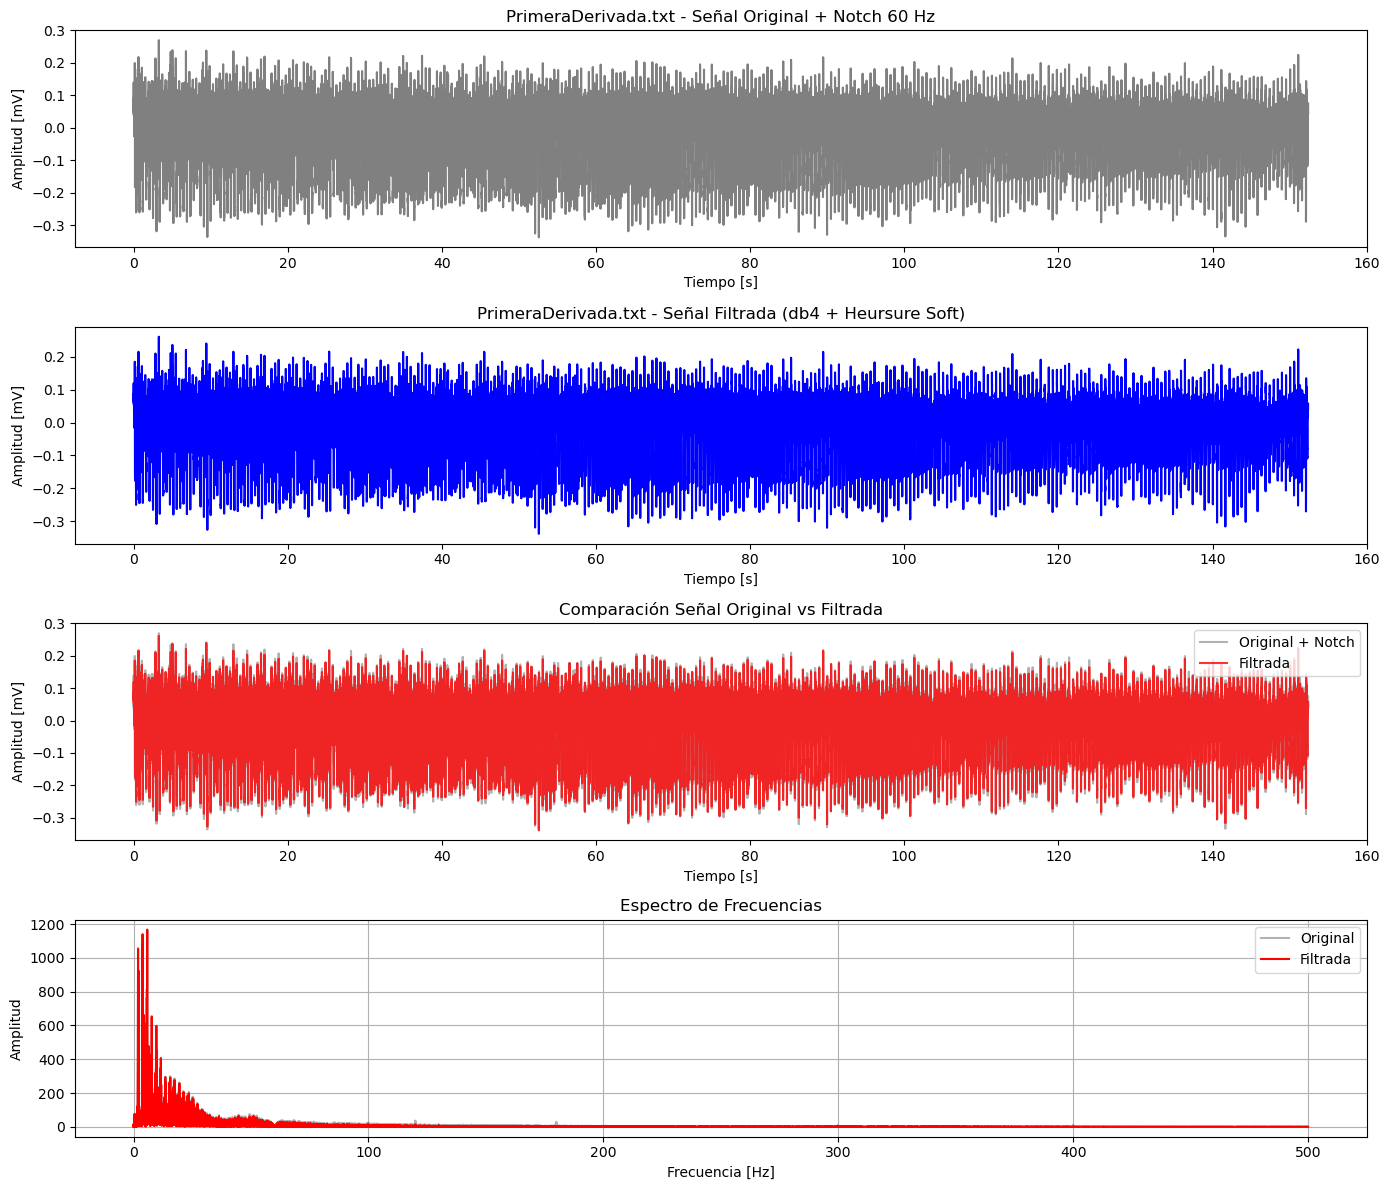

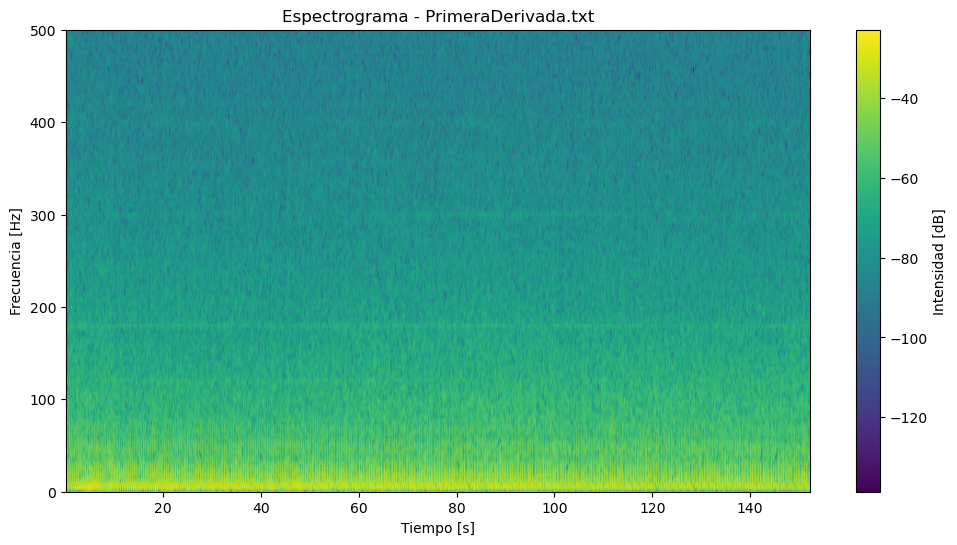

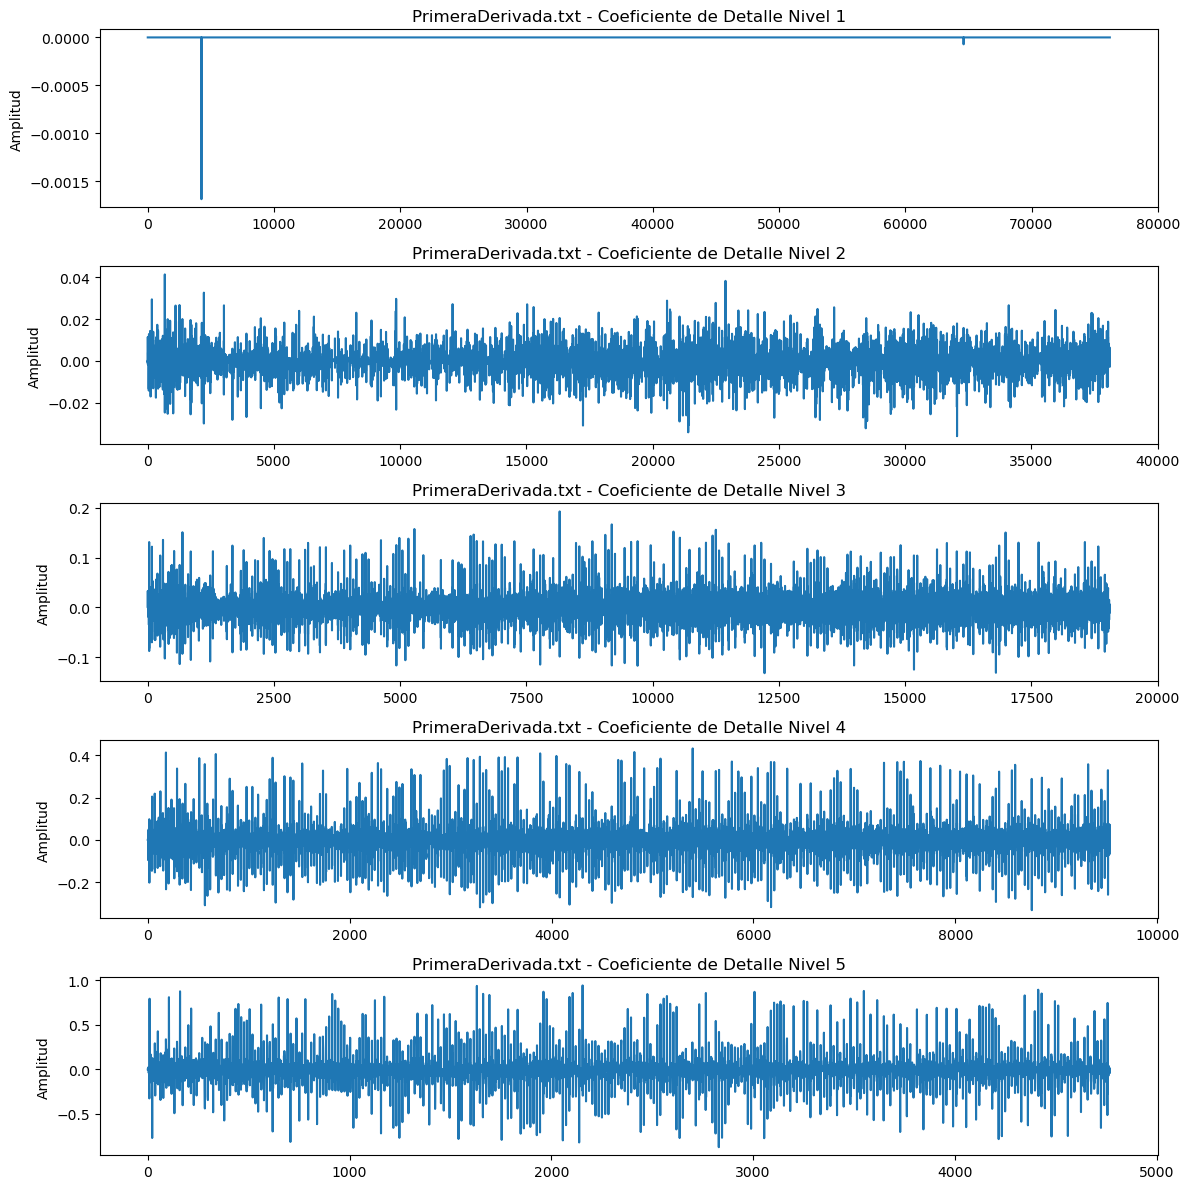


Archivo: SegundaDerivada.txt
MSE después del filtrado: 0.0001
SNR después del filtrado: 16.51 dB


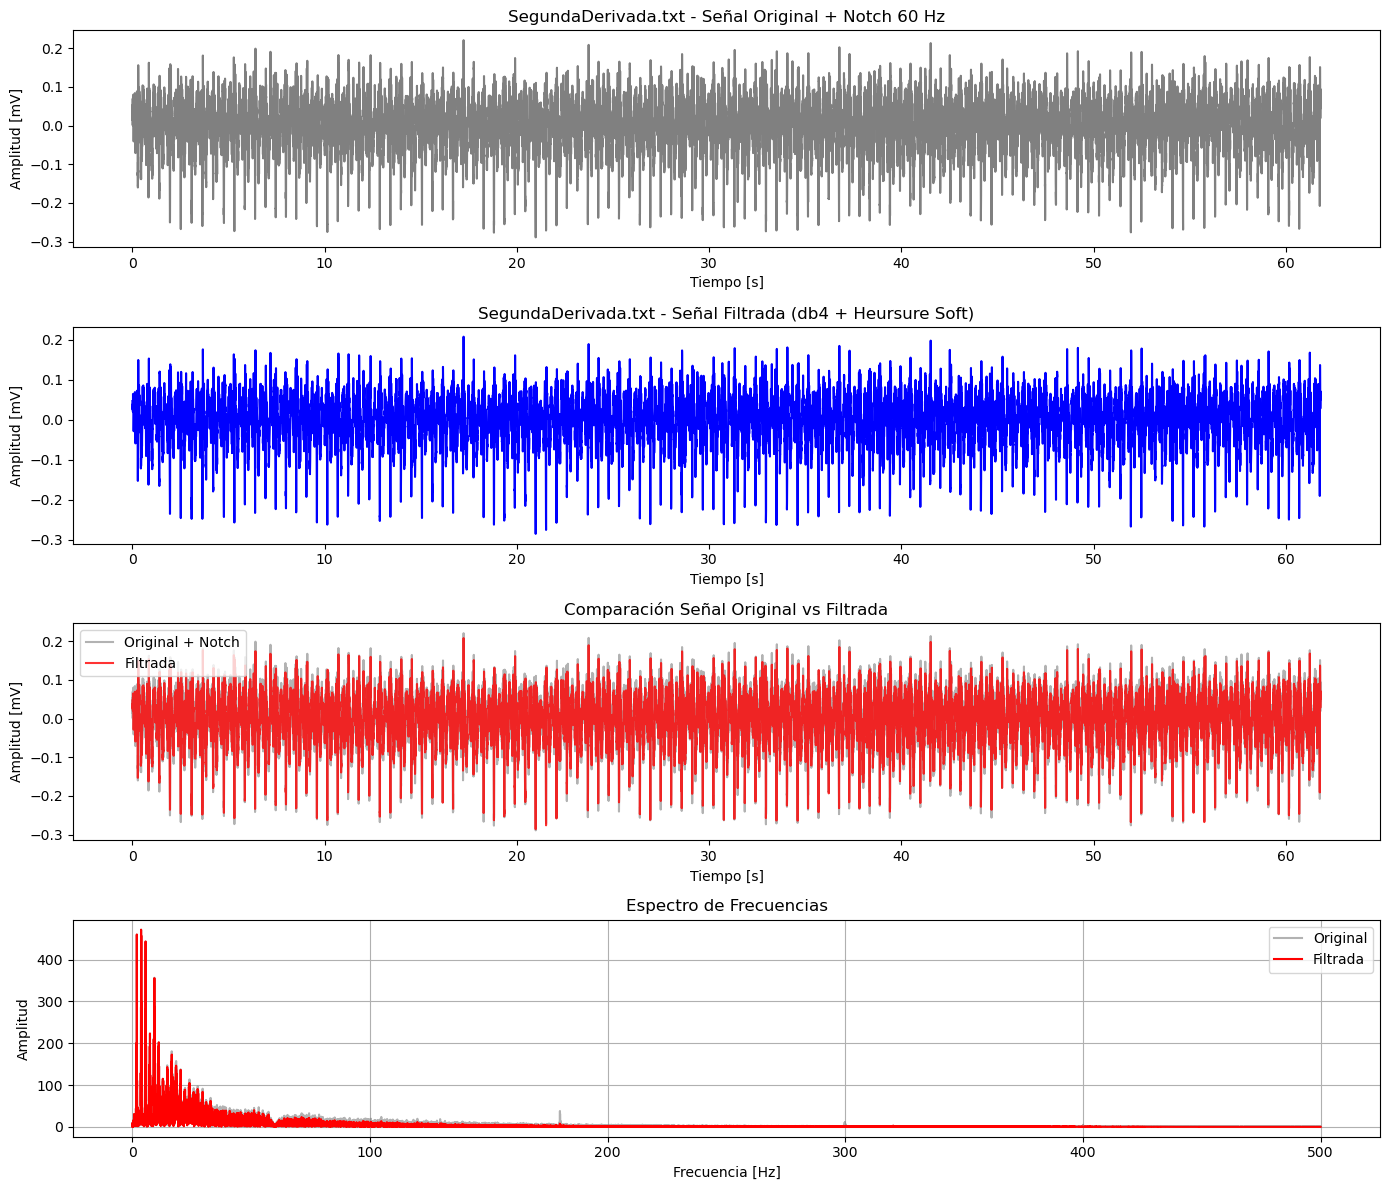

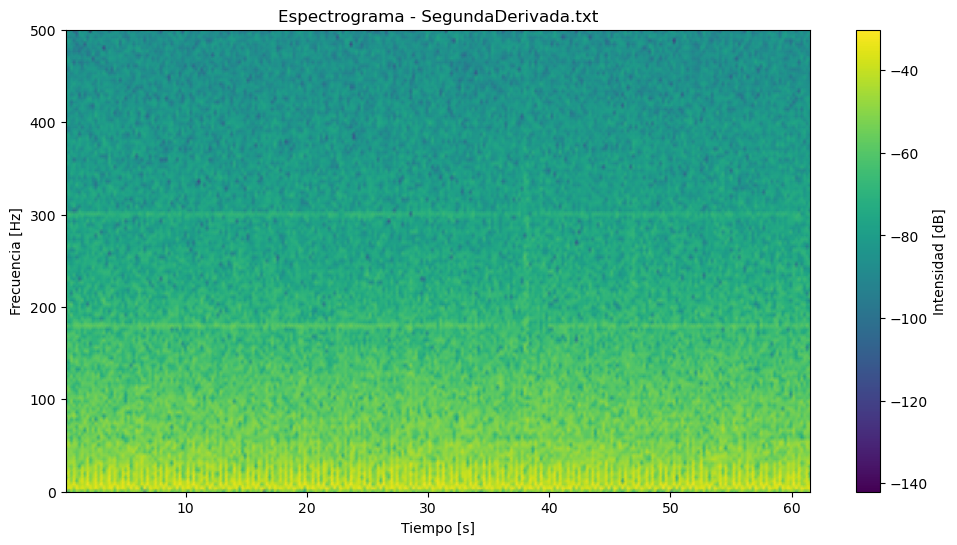

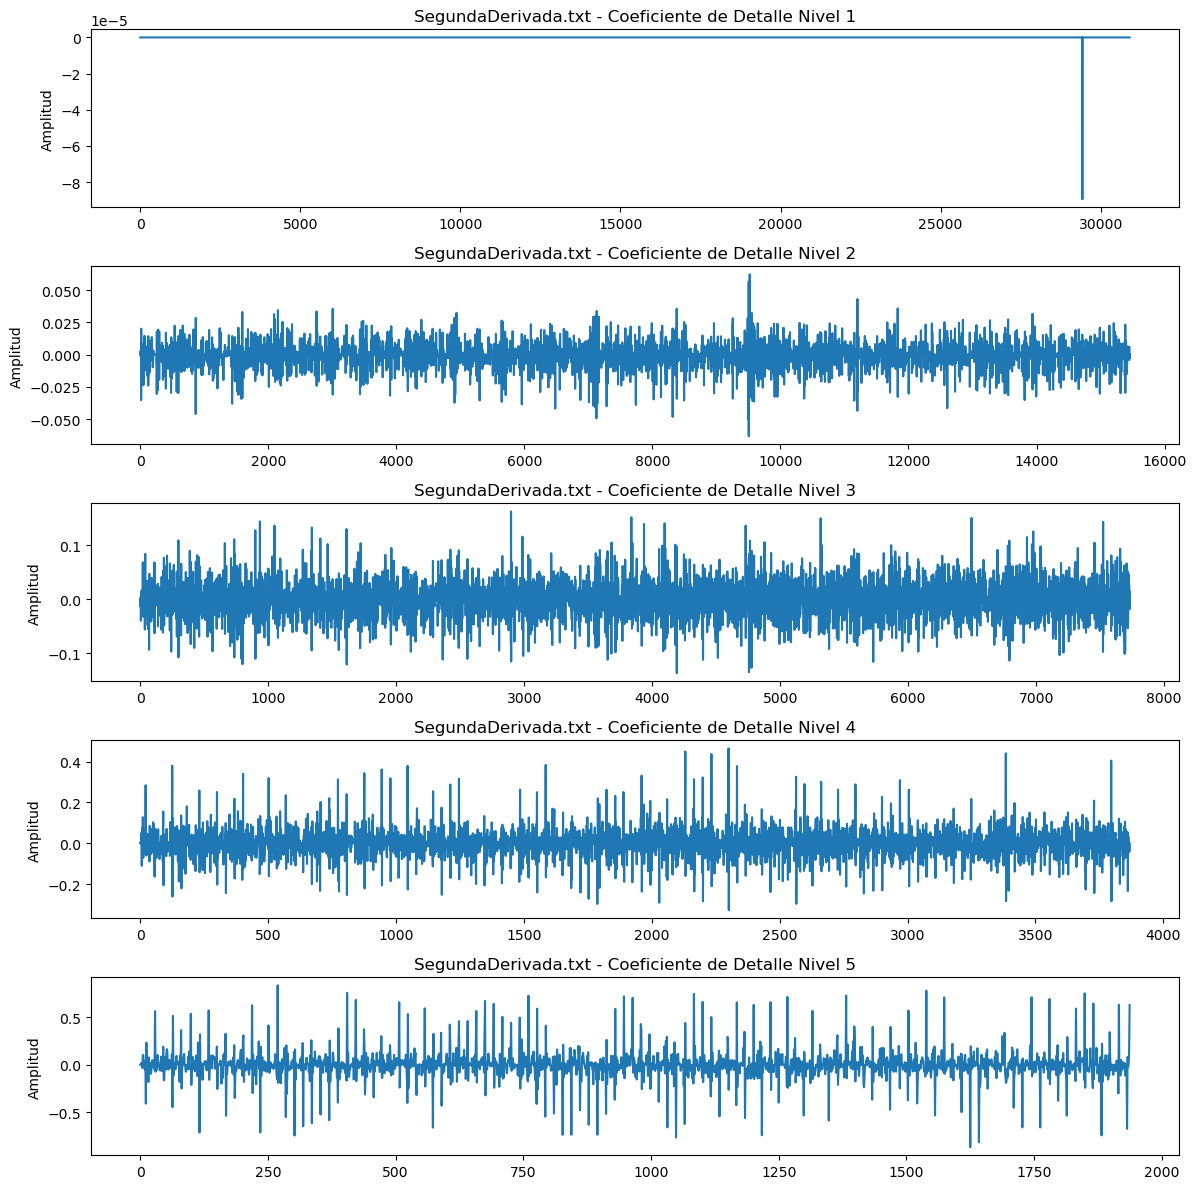


Archivo: RESPIRARECG1.txt
MSE después del filtrado: 0.0001
SNR después del filtrado: 13.93 dB


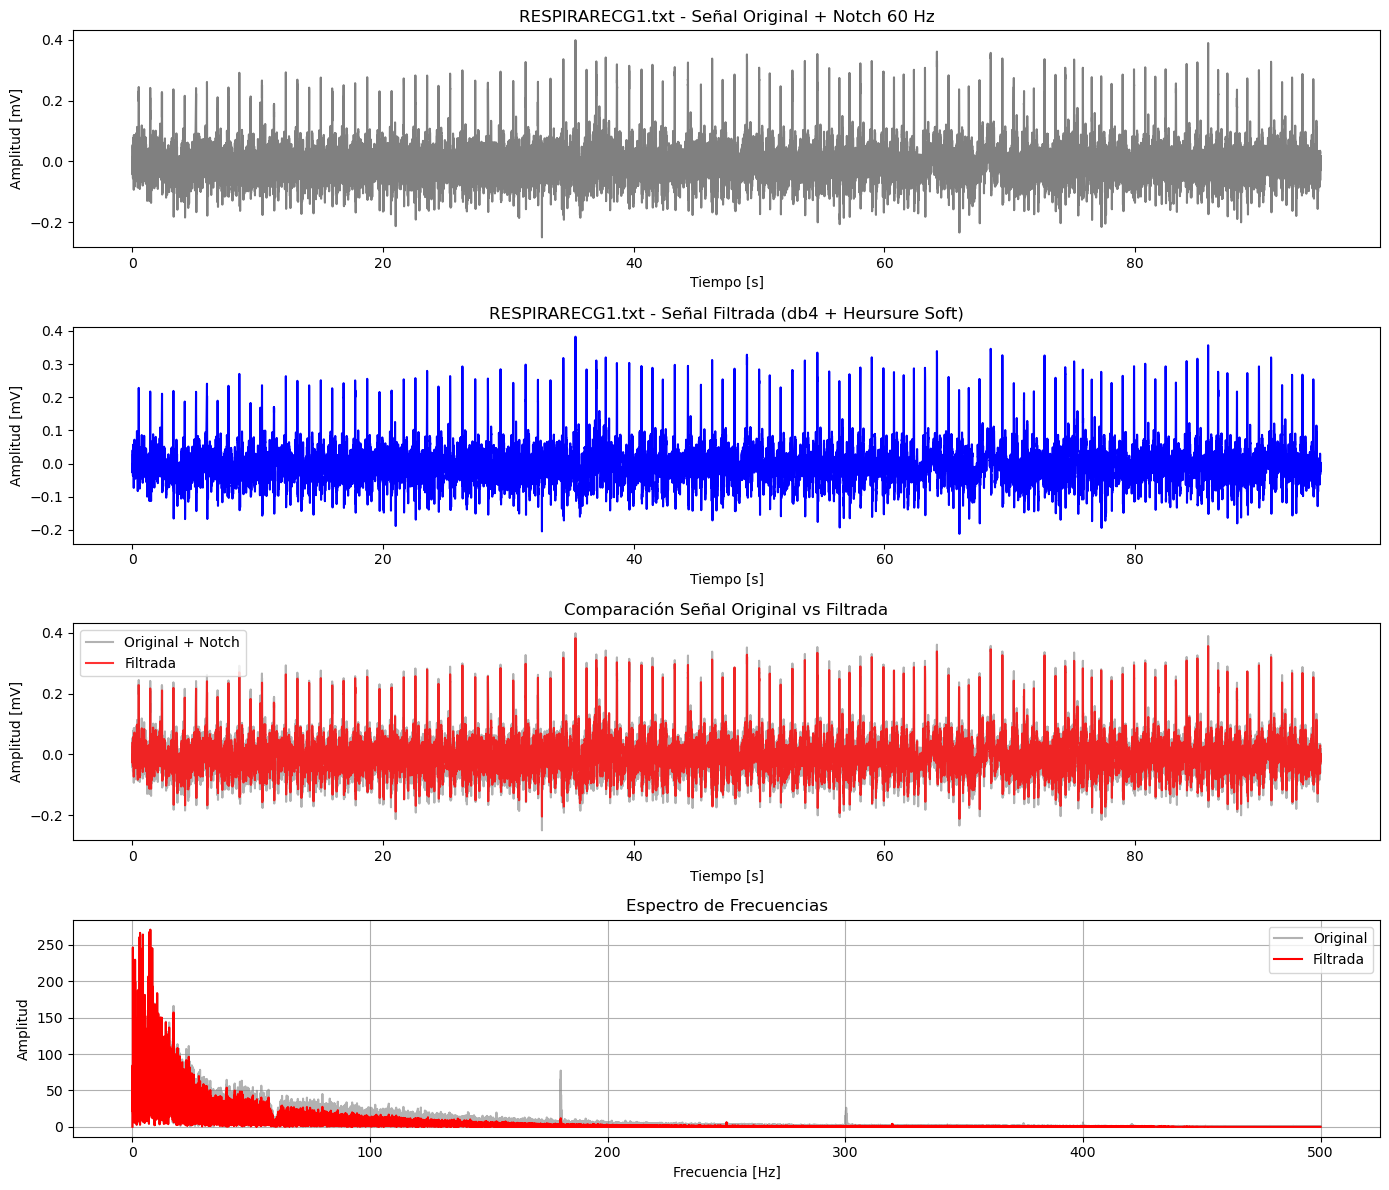

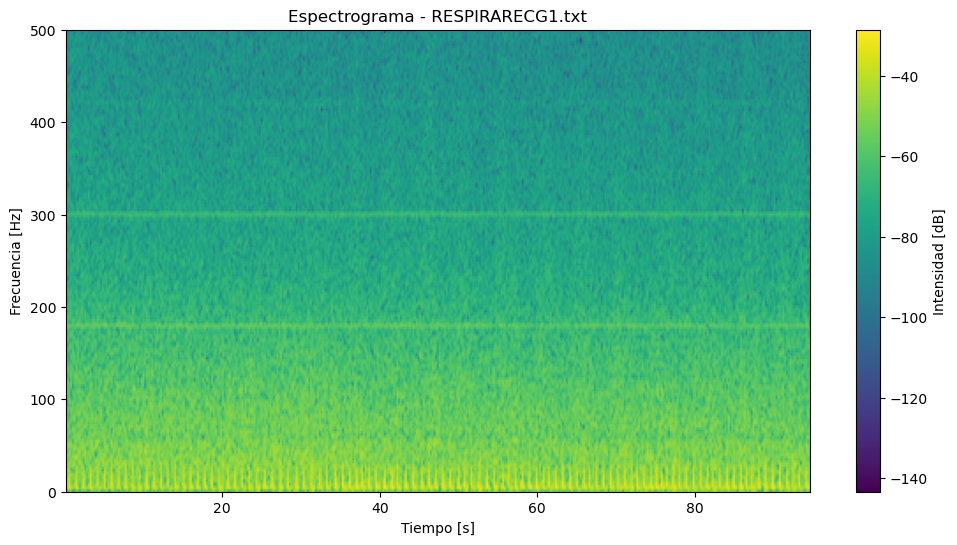

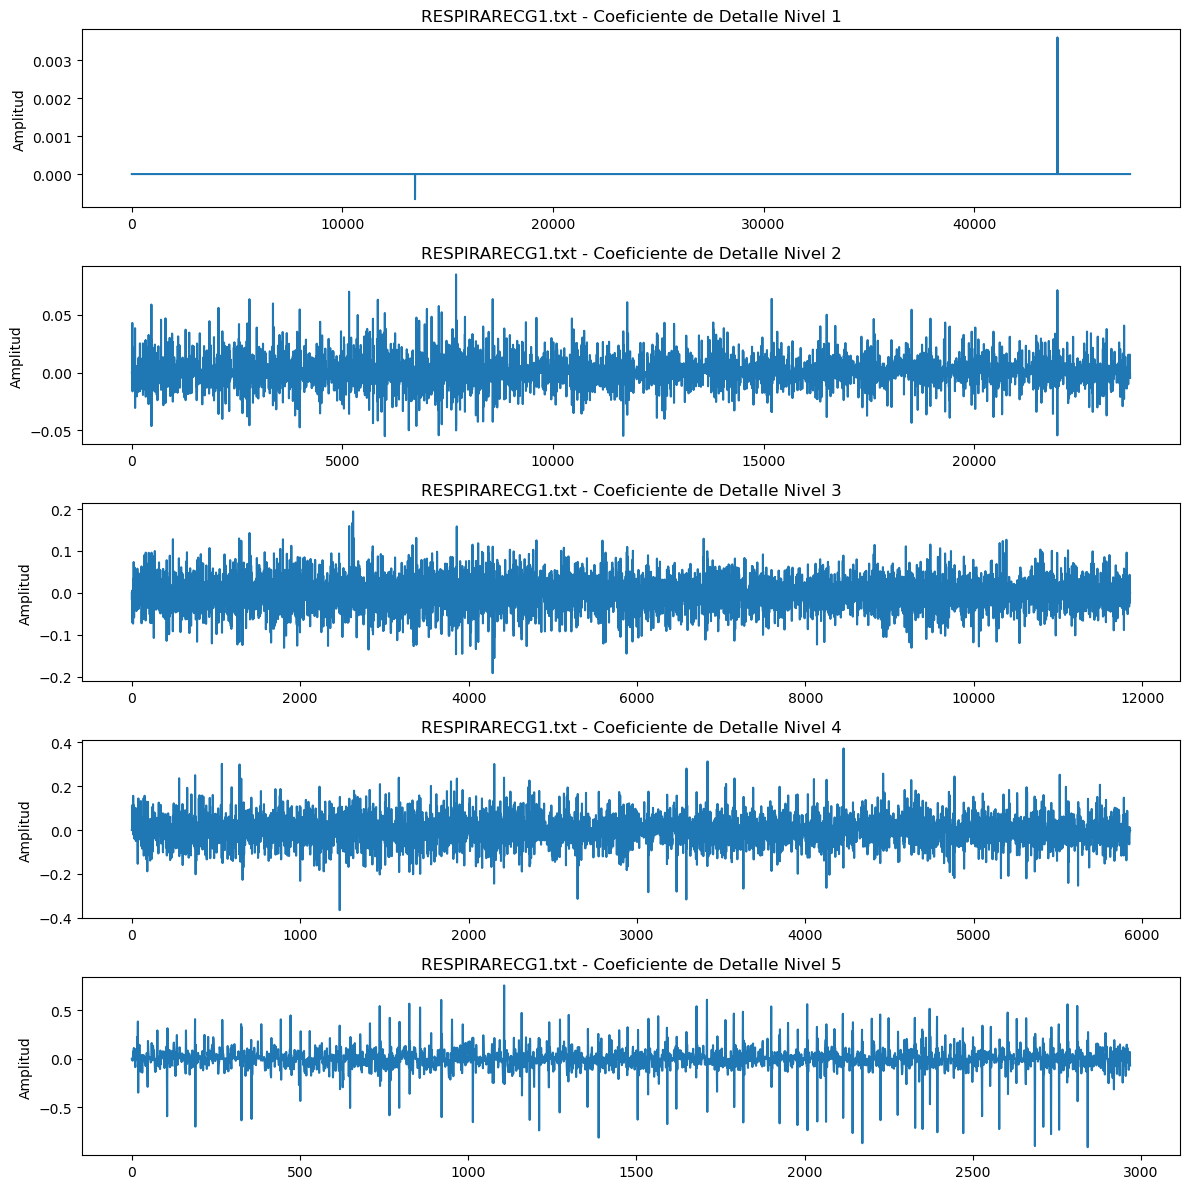

In [7]:
# =============================================================================
# FILTRADO WAVELET PARA MULTIPLES SEÑALES ECG - db4 + Heursure Soft + Notch 60 Hz
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy import signal
from sklearn.metrics import mean_squared_error
import os

# === 1. Carpeta y lista de archivos ===
carpeta = r"C:\SeñalesLab3\Lab4"
archivos = ["ReposoECG_original.txt", "PrimeraDerivada.txt", 
            "SegundaDerivada.txt", "RESPIRARECG1.txt"]

# === 2. Parámetros del sensor ===
VCC = 3.3
Gain = 1100      # Ganancia corregida
ADCres = 1023
fs = 1000  # Frecuencia de muestreo [Hz]

# === 3. Parámetros Wavelet ===
wavelet = 'db4'
nivel = 5

# === 4. Filtro notch 60 Hz ===
f0 = 60.0    # Frecuencia a eliminar [Hz]
Q = 30.0     # Factor de calidad
b_notch, a_notch = signal.iirnotch(f0, Q, fs)

# === 5. Procesar cada archivo ===
for archivo in archivos:
    ruta = os.path.join(carpeta, archivo)
    df = pd.read_csv(ruta, sep="\t", comment="#",
                     names=["nSeq", "I1", "I2", "O1", "O2", "A1"])
    
    ECG_raw = df["O2"].values
    t = np.arange(len(ECG_raw)) / fs
    
    # Conversión ADC → mV y quitar DC
    ECG_V = ((ECG_raw / ADCres) - 0.5) * VCC / Gain
    ECG_mV = ECG_V * 1000
    ECG_noDC = ECG_mV - np.mean(ECG_mV)
    
    # --- Aplicar filtro notch 60 Hz ---
    ECG_noDC_notch = signal.filtfilt(b_notch, a_notch, ECG_noDC)
    
    # --- Filtrado Wavelet ---
    coeficientes = pywt.wavedec(ECG_noDC_notch, wavelet, level=nivel)
    
    # Estimación de sigma a partir del primer nivel de detalle
    detalle_1 = coeficientes[-1]
    sigma = np.median(np.abs(detalle_1)) / 0.6745
    n = len(ECG_noDC_notch)
    umbral_universal = sigma * np.sqrt(2 * np.log(n))
    umbral_heur = umbral_universal if np.sum(detalle_1**2) < n*(sigma**2) else umbral_universal
    
    # Aplicar umbral soft
    coef_filtrados = [coeficientes[0]]
    for c in coeficientes[1:]:
        coef_filtrados.append(pywt.threshold(c, umbral_heur, mode='soft'))
    
    # Reconstrucción de la señal filtrada
    ECG_filtrada = pywt.waverec(coef_filtrados, wavelet)
    
    # --- Métricas ---
    mse_val = mean_squared_error(ECG_noDC_notch, ECG_filtrada)
    snr_val = 10 * np.log10(np.sum(ECG_noDC_notch**2) / np.sum((ECG_noDC_notch - ECG_filtrada)**2))
    
    print(f"\nArchivo: {archivo}")
    print(f"MSE después del filtrado: {mse_val:.4f}")
    print(f"SNR después del filtrado: {snr_val:.2f} dB")
    
    # --- Gráficas ---
    plt.figure(figsize=(14, 12))

    # Señal original + Notch
    plt.subplot(4, 1, 1)
    plt.plot(t, ECG_noDC_notch, color='gray')
    plt.title(f"{archivo} - Señal Original + Notch 60 Hz")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [mV]")

    # Señal filtrada
    plt.subplot(4, 1, 2)
    plt.plot(t, ECG_filtrada, color='blue')
    plt.title(f"{archivo} - Señal Filtrada (db4 + Heursure Soft)")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [mV]")

    # Comparación original vs filtrada
    plt.subplot(4, 1, 3)
    plt.plot(t, ECG_noDC_notch, label="Original + Notch", color='gray', alpha=0.6)
    plt.plot(t, ECG_filtrada, label="Filtrada", color='red', alpha=0.8)
    plt.title("Comparación Señal Original vs Filtrada")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [mV]")
    plt.legend()

    # Espectro de frecuencias
    plt.subplot(4, 1, 4)
    frecuencias = np.fft.fftfreq(len(ECG_noDC_notch), 1/fs)
    X_original = np.fft.fft(ECG_noDC_notch)
    X_filtrada = np.fft.fft(ECG_filtrada)
    plt.plot(frecuencias[:len(frecuencias)//2], np.abs(X_original[:len(frecuencias)//2]), label='Original', color='gray', alpha=0.6)
    plt.plot(frecuencias[:len(frecuencias)//2], np.abs(X_filtrada[:len(frecuencias)//2]), label='Filtrada', color='red')
    plt.title("Espectro de Frecuencias")
    plt.xlabel("Frecuencia [Hz]")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    # --- Espectrograma (opcional) ---
    f, t_spec, Sxx = signal.spectrogram(ECG_noDC_notch, fs)
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frecuencia [Hz]')
    plt.xlabel('Tiempo [s]')
    plt.title(f'Espectrograma - {archivo}')
    plt.colorbar(label='Intensidad [dB]')
    plt.show()

    # --- Coeficientes de detalle (opcional) ---
    plt.figure(figsize=(12, 12))
    for i in range(1, nivel+1):
        plt.subplot(nivel, 1, i)
        plt.plot(coef_filtrados[nivel-i+1])
        plt.title(f'{archivo} - Coeficiente de Detalle Nivel {i}')
        plt.ylabel('Amplitud')
    plt.tight_layout()
    plt.show()



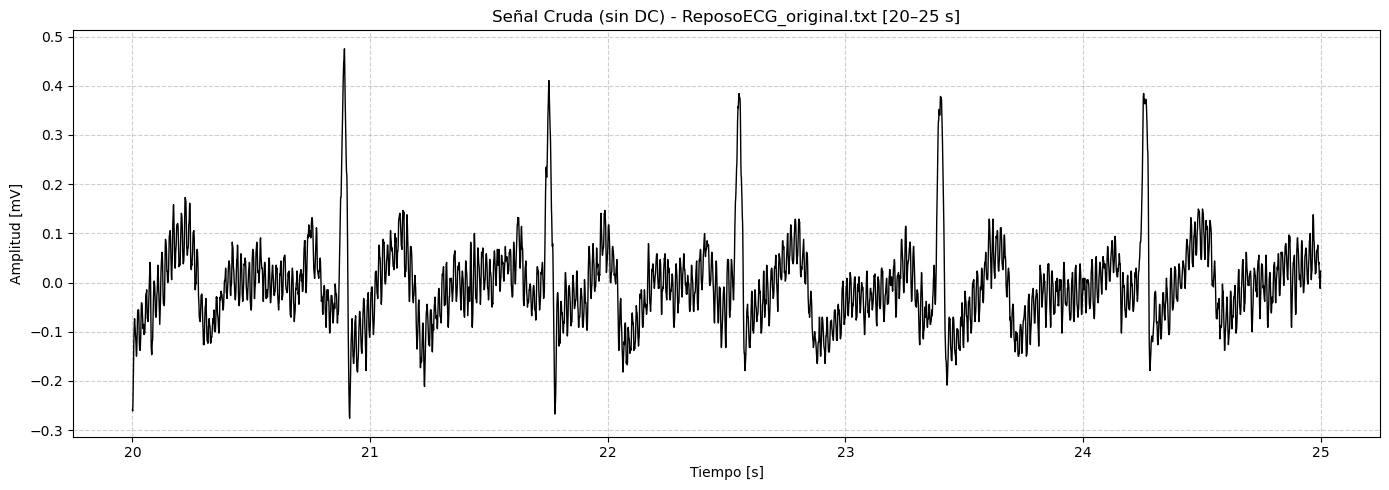

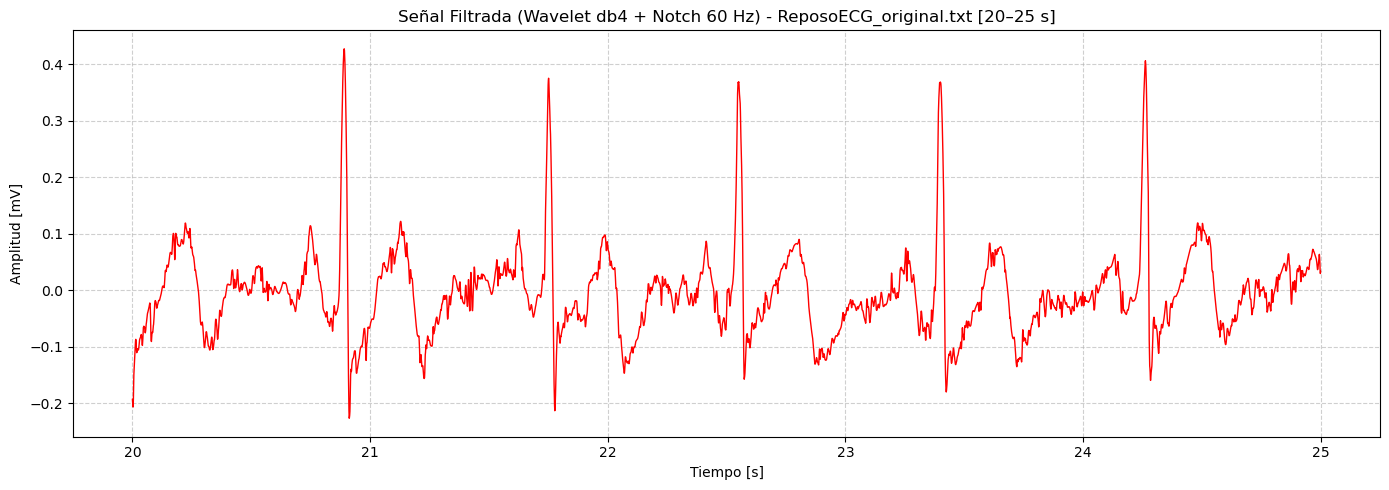

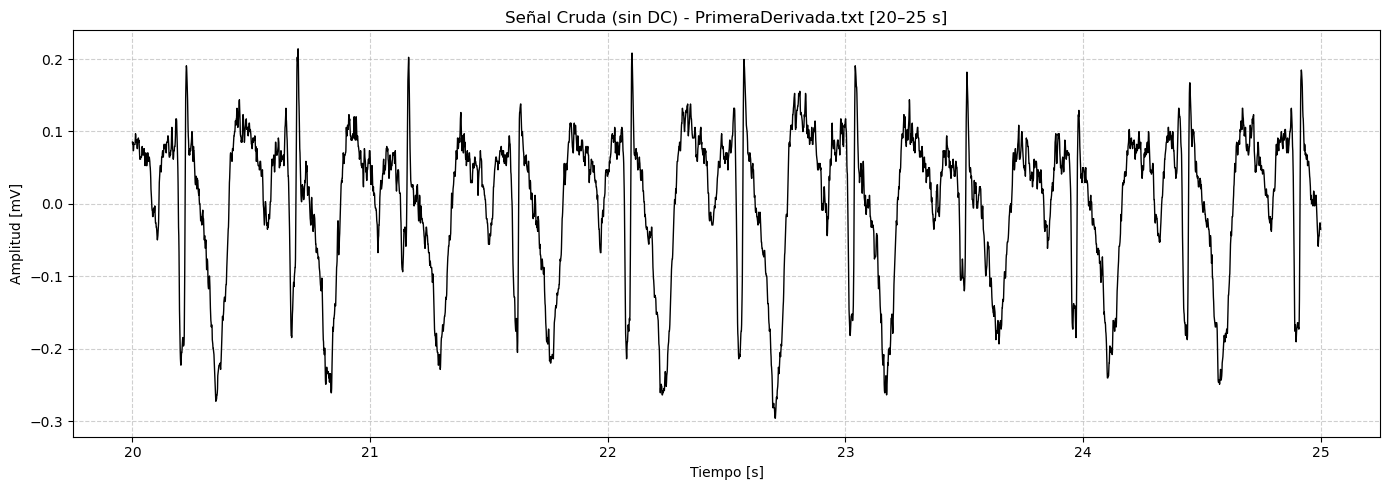

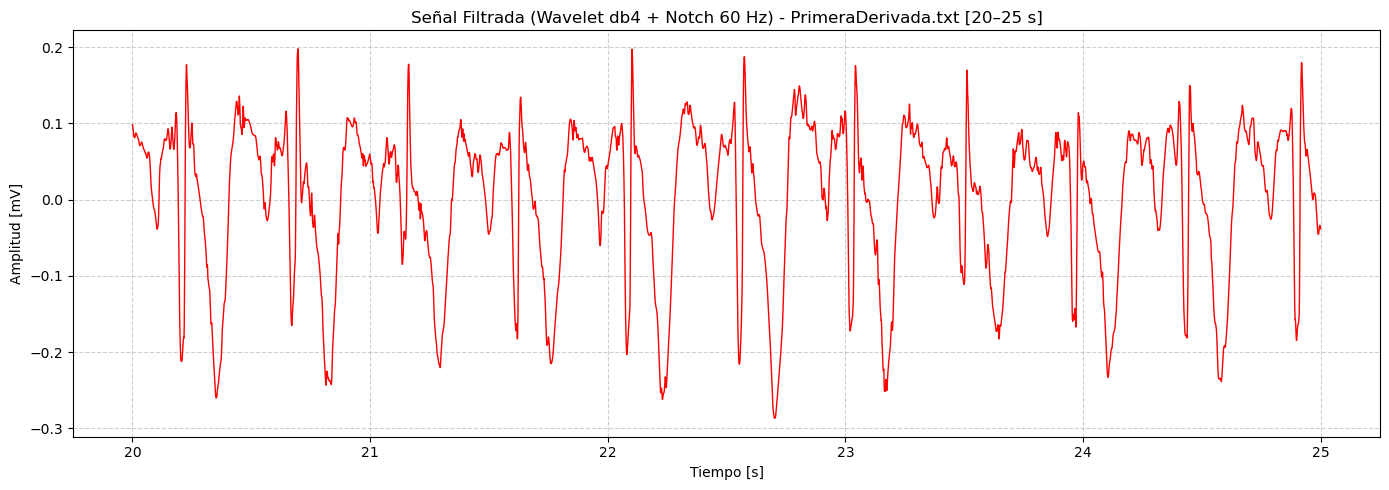

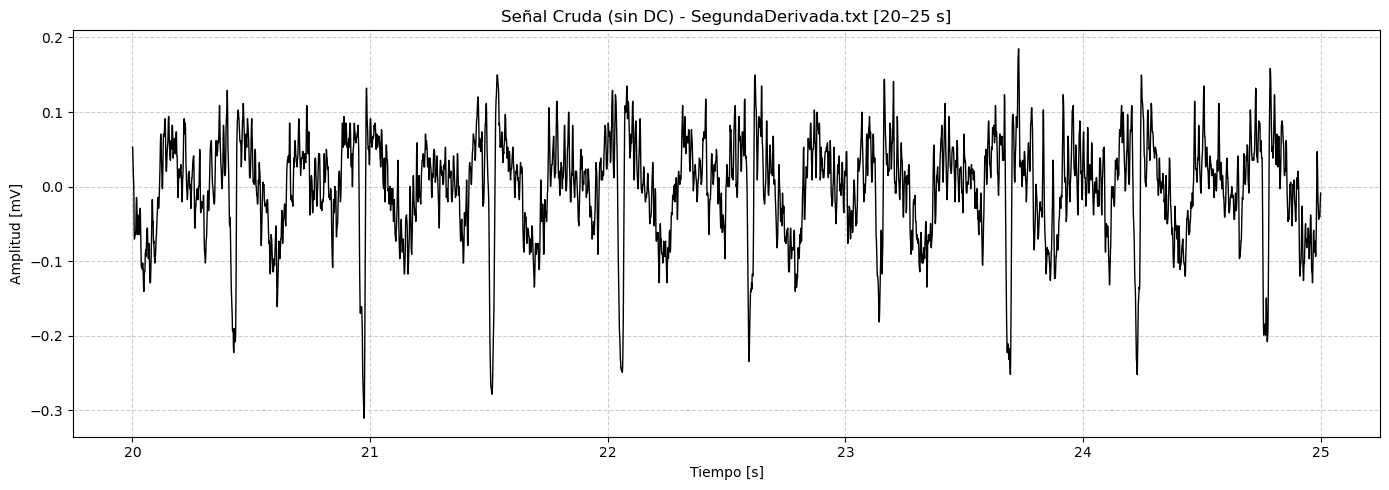

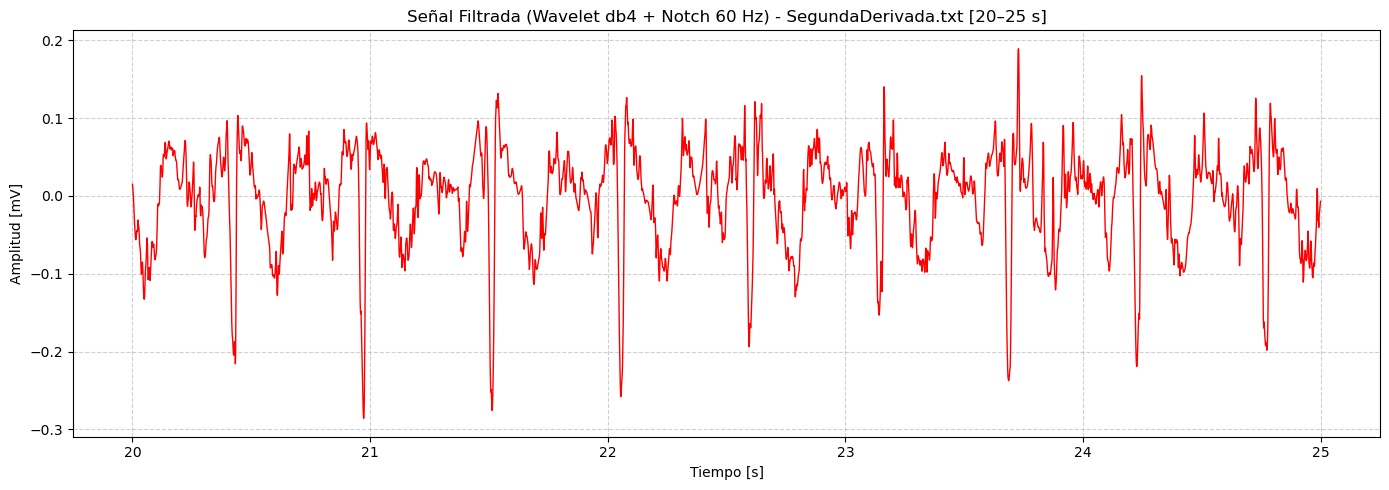

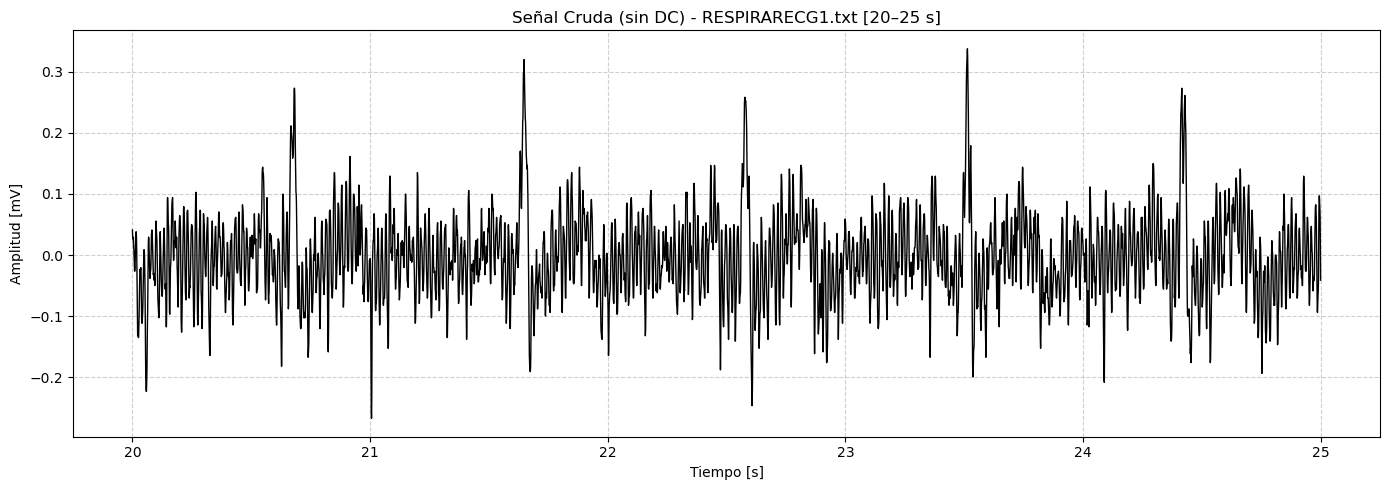

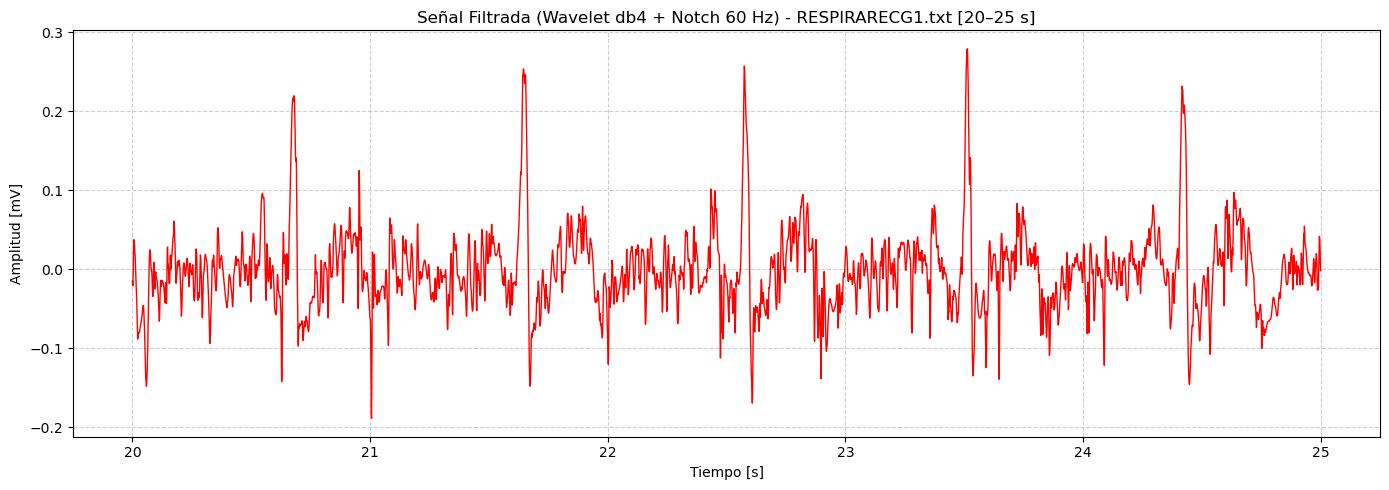

In [11]:
# =============================================================================
# COMPARACIÓN SEÑAL CRUDA Y FILTRADA WAVELET - ECG (db4 + Notch 60 Hz)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy import signal
import os

# === 1. Carpeta y lista de archivos ===
carpeta = r"C:\SeñalesLab3\Lab4"
archivos = ["ReposoECG_original.txt", "PrimeraDerivada.txt", 
            "SegundaDerivada.txt", "RESPIRARECG1.txt"]

# === 2. Parámetros del sensor ===
VCC = 3.3
Gain = 1100
ADCres = 1023
fs = 1000  # [Hz]

# === 3. Wavelet y Notch ===
wavelet = 'db4'
nivel = 5
f0 = 60.0
Q = 30.0
b_notch, a_notch = signal.iirnotch(f0, Q, fs)

# === 4. Procesar cada archivo ===
for archivo in archivos:
    ruta = os.path.join(carpeta, archivo)
    df = pd.read_csv(ruta, sep="\t", comment="#",
                     names=["nSeq", "I1", "I2", "O1", "O2", "A1"])
    
    ECG_raw = df["O2"].values
    t = np.arange(len(ECG_raw)) / fs

    # Conversión ADC → mV
    ECG_V = ((ECG_raw / ADCres) - 0.5) * VCC / Gain
    ECG_mV = ECG_V * 1000
    ECG_noDC = ECG_mV - np.mean(ECG_mV)

    # --- Filtro Notch 60 Hz ---
    ECG_notch = signal.filtfilt(b_notch, a_notch, ECG_noDC)

    # --- Filtrado Wavelet ---
    coeficientes = pywt.wavedec(ECG_notch, wavelet, level=nivel)
    detalle_1 = coeficientes[-1]
    sigma = np.median(np.abs(detalle_1)) / 0.6745
    n = len(ECG_notch)
    umbral_universal = sigma * np.sqrt(2 * np.log(n))

    coef_filtrados = [coeficientes[0]]
    for c in coeficientes[1:]:
        coef_filtrados.append(pywt.threshold(c, umbral_universal, mode='soft'))

    ECG_filtrada = pywt.waverec(coef_filtrados, wavelet)

    # === 5. Definir rango visible: 20 a 25 segundos ===
    t_ini = 20
    t_fin = 25
    idx_ini = int(t_ini * fs)
    idx_fin = int(t_fin * fs)

    t_zoom = t[idx_ini:idx_fin]
    ECG_cruda_zoom = ECG_noDC[idx_ini:idx_fin]
    ECG_filtrada_zoom = ECG_filtrada[idx_ini:idx_fin]

    # === GRAFICAR POR SEPARADO ===

    # --- 1️⃣ Señal cruda ---
    plt.figure(figsize=(14, 5))
    plt.plot(t_zoom, ECG_cruda_zoom, color='black', linewidth=1)
    plt.title(f"Señal Cruda (sin DC) - {archivo} [20–25 s]")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [mV]")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # --- 2️⃣ Señal filtrada ---
    plt.figure(figsize=(14, 5))
    plt.plot(t_zoom, ECG_filtrada_zoom, color='red', linewidth=1)
    plt.title(f"Señal Filtrada (Wavelet db4 + Notch 60 Hz) - {archivo} [20–25 s]")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [mV]")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

